**This is our notebook where we will explain our process of everything**

In [68]:
#cell for importing all libraries
import numpy as np
import pandas as pd
import scipy
import tensorflow
import shap
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
import matplotlib
import matplotlib.pyplot as plt

In [69]:
#cell for importing dataset
X_train = pd.read_csv("./data/X_train.csv")
y_train = pd.read_csv("./data/y_train.csv")
X_test = pd.read_csv("./data/X_test.csv")
y_test = pd.read_csv("./data/y_test.csv")

**We should probably drop the make data as well since the make is already included in the model that the car is**

In [70]:
#one hot encoding variables

#Makes sure that the test and training data always have all one-hot categories by combining before encoding then splitting again
X_combined = pd.concat([X_train,X_test],axis=0)

#dropping features that aren't useful
X_combined = X_combined.drop('brand', axis=1)
#X_combined = X_combined.drop('tax', axis=1)
X_combined = X_combined.drop('carID', axis=1)

X_combined = pd.get_dummies(X_combined)
col_names = list(X_combined.columns)

X_train = X_combined[:len(X_train)]
X_test = X_combined[len(X_train):]

#dropping data that isn't useful from y lists
y_train = y_train.drop('carID', axis=1)  # drop the CarID value since it's just an identifier
y_test = y_test.drop('carID', axis=1)  # drop the CarID value since it's just an identifier



#scaling data
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train))
X_test = pd.DataFrame(scaler.fit_transform(X_test))


#remove highly correlated data
corr_matrix = X_train.corr()
high_corr = corr_matrix[(corr_matrix > 0.9) & (corr_matrix != 1.0)].any()

# drop one of the highly correlated features
X_train.drop(high_corr.index[high_corr], axis=1, inplace=True)
X_test.drop(high_corr.index[high_corr], axis=1, inplace=True)


In [71]:
#basic logistic regression using dataset to produce model
#lr = LogisticRegression(max_iter=10000, solver="lbfgs")
lr = DecisionTreeRegressor(random_state=42)
lr.fit(X_train, y_train.to_numpy().ravel())

DecisionTreeRegressor(random_state=42)

In [72]:
pred = lr.predict(X_test)

dif = np.subtract(y_test["price"].to_numpy(),pred)
precentage_dif = np.divide(dif,y_test["price"].to_numpy())
precentage_dif *= 100
r2_val = r2_score(y_test,pred)
adj_r2 = 1 - (1- r2_val) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)

In [73]:
print(adj_r2)
print(np.mean(precentage_dif))

0.9067838978348659
-0.8997571943143816


We should try an SVR(svm) approach to see if it would improve our results

In [74]:
explainer = shap.Explainer(lr.predict, X_test, feature_names=col_names)
shap_values = explainer(X_test)

Permutation explainer: 2673it [02:26, 16.97it/s]                          


['year', 'mileage', 'tax', 'mpg', 'engineSize', 'model_ 6 Series', 'model_ 7 Series', 'model_ 8 Series', 'model_ A7', 'model_ A8', 'model_ Agila', 'model_ Amarok', 'model_ Antara', 'model_ Arteon', 'model_ Avensis', 'model_ Beetle', 'model_ CC', 'model_ CLA Class', 'model_ CLK', 'model_ CLS Class', 'model_ Caddy', 'model_ Caddy Life', 'model_ Caddy Maxi Life', 'model_ California', 'model_ Camry', 'model_ Caravelle', 'model_ Combo Life', 'model_ Edge', 'model_ Eos', 'model_ Fusion', 'model_ G Class', 'model_ GL Class', 'model_ GLB Class', 'model_ GLS Class', 'model_ GT86', 'model_ GTC', 'model_ Galaxy', 'model_ Getz', 'model_ Grand C-MAX', 'model_ Grand Tourneo Connect', 'model_ Hilux', 'model_ I40', 'model_ I800', 'model_ IQ', 'model_ IX20', 'model_ IX35', 'model_ Jetta', 'model_ KA', 'model_ Kamiq', 'model_ Land Cruiser', 'model_ M Class', 'model_ M2', 'model_ M3', 'model_ M4', 'model_ M5', 'model_ M6', 'model_ Mustang', 'model_ PROACE VERSO', 'model_ Prius', 'model_ Puma', 'model_ Q8

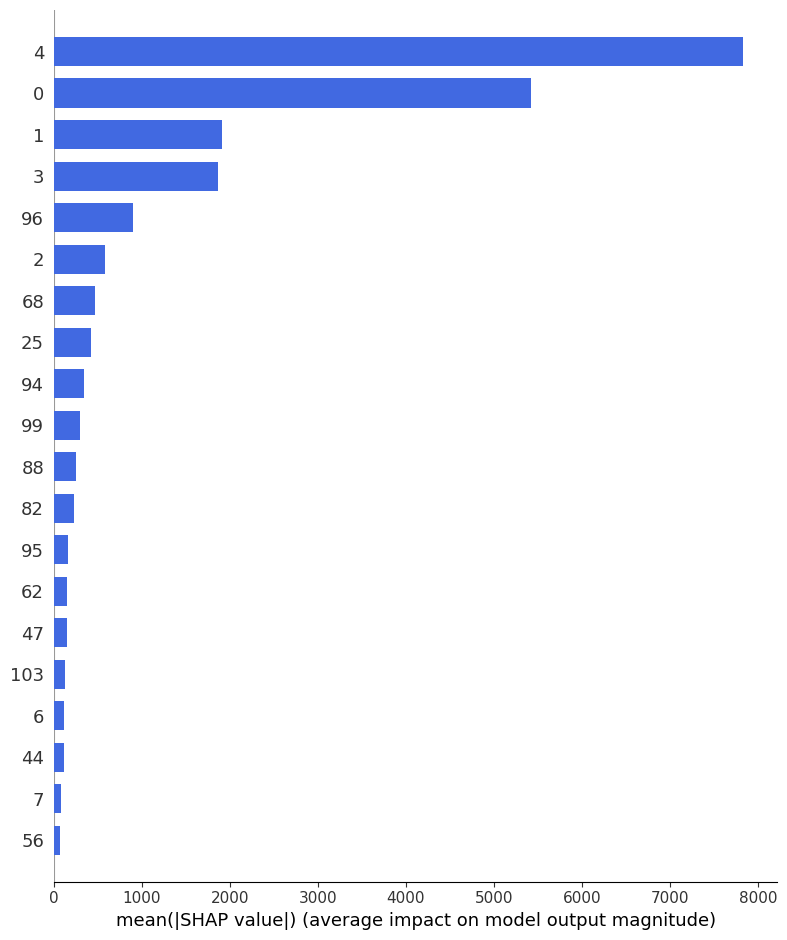

In [79]:
#shap.plots.waterfall(shap_values)
print(explainer.feature_names)
plt.figure()
shap.summary_plot(shap_values, X_test, plot_type='bar', color='royalblue', show=False)
plt.show()

- Using simple logistic regression and one hot encoding, our model is able to get and adjusted $r^2$ value of 0.87 which is pretty good. 
- On average, our model under estimates price by 3.3%.

From here we should work on tuning the hyperparameters of our model and discovering feature importance